In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import pickle
import random
from sklearn.preprocessing import MinMaxScaler

In [46]:
df = pd.read_csv("/content/amazon_eda_clean.csv")

In [47]:
print("Shape:", df.shape)

Shape: (177008, 36)


Detect numeric and cat columns

In [48]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

Outliers Detection & Handling

In [49]:
z_scores = np.abs(stats.zscore(df[num_cols], nan_policy='omit'))
outliers = (z_scores > 3).sum(axis=0)
outlier_summary = pd.DataFrame({
    'Column': num_cols,
    'Outlier_Count': outliers,
    'Outlier_Percent': (outliers / len(df)) * 100
}).sort_values(by='Outlier_Percent', ascending=False)

print("\n🚨 Outlier Summary (Top 10 columns):")
print(outlier_summary.head(10))


🚨 Outlier Summary (Top 10 columns):
             Column  Outlier_Count  Outlier_Percent
1               qty          13195         7.454465
5              year          10450         5.903688
6             month           5950         3.361430
2            amount           2850         1.610097
4             stock           1320         0.745729
3  ship-postal-code              2         0.001130
0             index              0         0.000000
7           weekday              0         0.000000
8        is_weekend              0         0.000000
9   monthly_expense              0         0.000000


Visualize distributions for key numerical columns

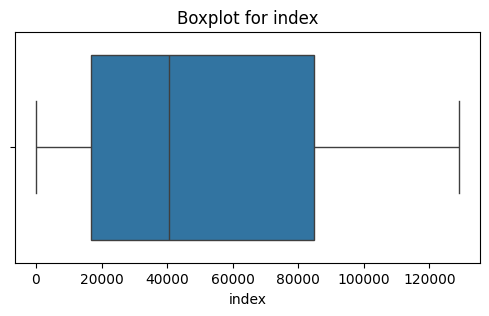

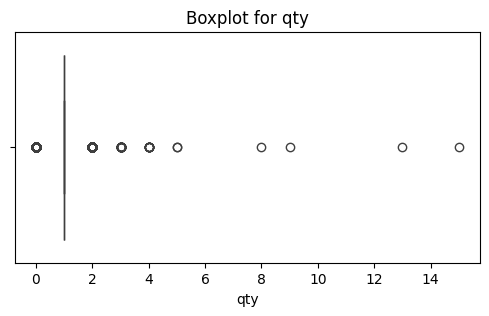

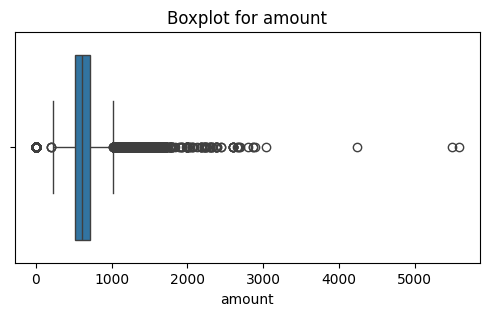

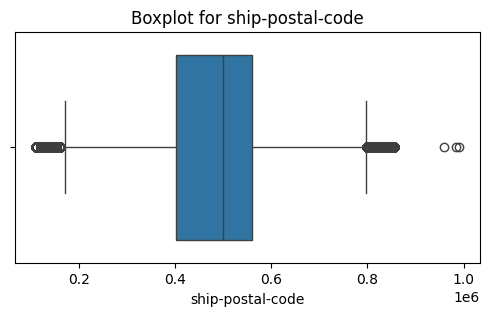

In [50]:
for col in num_cols[:4]:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()


 Capping outliers at 1st and 99th percentile

In [51]:
for col in num_cols:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = np.clip(df[col], lower, upper)

print("\n✅ Outliers capped at 1st and 99th percentiles.")



✅ Outliers capped at 1st and 99th percentiles.


Missing Values Handling

In [52]:
print("\n🔍 Checking missing values after EDA...")

missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_df = pd.DataFrame({
    "Missing_Count": missing,
    "Missing_Percent": (missing / len(df)) * 100
})

print("\n📋 Missing Values Summary:")
print(missing_df.head(10))



🔍 Checking missing values after EDA...

📋 Missing Values Summary:
                Missing_Count  Missing_Percent
rate                   140616        79.440477
customer               140616        79.440477
gross_amt              140616        79.440477
months                 139601        78.867057
fulfilled-by           137731        77.810607
promotion-ids           97186        54.904863
unnamed:_22             97083        54.846674
currency                55828        31.539817
courier_status          54905        31.018372
ship-city               48068        27.155835


In [53]:
# Drop columns with >70% missing values
threshold = 70
cols_to_drop = missing_df[missing_df["Missing_Percent"] > threshold].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)
print(f"\n🗑️ Dropped {len(cols_to_drop)} columns with more than {threshold}% missing values:")
print(cols_to_drop)

# Recalculate missing after dropping
remaining_missing = df.isna().sum()
remaining_missing = remaining_missing[remaining_missing > 0].sort_values(ascending=False)
print("\n✅ Remaining missing columns (after drop):")
print(remaining_missing)



🗑️ Dropped 5 columns with more than 70% missing values:
['rate', 'customer', 'gross_amt', 'months', 'fulfilled-by']

✅ Remaining missing columns (after drop):
promotion-ids         97186
unnamed:_22           97083
currency              55828
courier_status        54905
ship-city             48068
ship-state            48066
ship-country          48066
order_id              48033
status                48033
fulfilment            48033
asin                  48033
ship-service-level    48033
sales_channel         48033
b2b                   48033
category              37477
sku                   11745
style                 11641
size                   2406
dtype: int64


Impute remaining missing values

In [54]:
if "category" in df.columns:
    for col in num_cols:
        df[col] = df.groupby("category")[col].transform(
            lambda x: x.interpolate(method="linear", limit_direction="both")
        )
print("📈 Interpolation by category (linear trend) applied to numerical features.")


📈 Interpolation by category (linear trend) applied to numerical features.


Random min–max imputation

In [55]:
def random_impute(series):
    non_missing = series.dropna()
    if non_missing.empty:
        return series
    min_val, max_val = non_missing.min(), non_missing.max()
    return series.apply(lambda x: random.uniform(min_val, max_val) if pd.isna(x) else x)

for col in ['qty', 'amount', 'monthly_expense']:
    if col in df.columns:
        df[col] = random_impute(df[col])

print("🎲 Random min–max imputation applied for: qty, amount, monthly_expense.")


🎲 Random min–max imputation applied for: qty, amount, monthly_expense.


Fill categorical missing values with “Unknown”

In [56]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("📋 Detected categorical columns:")
print(cat_cols)

# Fill missing values in categorical columns with "Unknown"
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")
    else:
        # This is just a safeguard in case cat_cols contains a name not in df
        print(f"⚠️ Column '{col}' not found in dataframe — skipped.")


📋 Detected categorical columns:
['order_id', 'date', 'status', 'fulfilment', 'sales_channel', 'ship-service-level', 'style', 'sku', 'category', 'size', 'asin', 'courier_status', 'currency', 'ship-city', 'ship-state', 'ship-country', 'promotion-ids', 'b2b', 'unnamed:_22']


 Final median/mode

In [57]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical → mode
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("✅ Final median/mode imputation applied.")

✅ Final median/mode imputation applied.


Normalization

In [58]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print("⚖️ Min–Max normalization applied to numeric features.")

⚖️ Min–Max normalization applied to numeric features.


In [59]:
total_missing = df.isna().sum().sum()
print(f"\n✨ Total remaining missing values: {total_missing}")

print("\n🧠 Data Cleansing Completed Successfully!")



✨ Total remaining missing values: 0

🧠 Data Cleansing Completed Successfully!


In [62]:
df.head(10)

,order_id,date,status,fulfilment,sales_channel,ship-service-level,style,sku,category,size,...,b2b,unnamed:_22,stock,year,month,weekday,is_weekend,monthly_expense,month_total_qty,expense_per_unit_month
0,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,men5028,men5028 kr xxl,Unknown,xxl,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.181631,0.657174,0.0
1,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,bl103,bl103 s,Unknown,s,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.281592,0.657174,0.0
2,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,bl104,bl104 xl,Unknown,xl,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.764994,0.657174,0.0
3,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,bl104,bl104 m,Unknown,m,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.670251,0.657174,0.0
4,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,bl097,bl097 m,Unknown,m,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.303040,0.657174,0.0
5,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,men5006,men5006 kr xl,Unknown,xl,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.696021,0.657174,0.0
6,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,men5028,men5028 kr l,Unknown,l,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.696132,0.657174,0.0
7,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,men5003,men5003 kr xxl,Unknown,xxl,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.535895,0.657174,0.0
8,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,men5013,men5013 kr xxl,Unknown,xxl,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.314296,0.657174,0.0
9,Unknown,2021-06-05,Unknown,Unknown,Unknown,Unknown,men5013,men5013 kr s,Unknown,s,...,Unknown,Unknown,0.157895,0.0,0.666667,0.5,0.0,0.255259,0.657174,0.0


In [63]:
unknown_summary = {}
for col in df.select_dtypes(include="object"):
    unknown_summary[col] = (df[col] == "Unknown").mean() * 100

unknown_summary = pd.DataFrame.from_dict(unknown_summary, orient='index', columns=['Percent_Unknown']).sort_values(by='Percent_Unknown', ascending=False)
print(unknown_summary)


                    Percent_Unknown
promotion-ids             54.904863
unnamed:_22               54.846674
currency                  31.539817
courier_status            31.018372
ship-city                 27.155835
ship-country              27.154705
ship-state                27.154705
asin                      27.136062
status                    27.136062
order_id                  27.136062
fulfilment                27.136062
sales_channel             27.136062
ship-service-level        27.136062
b2b                       27.136062
category                  21.172489
sku                        6.635293
style                      6.576539
size                       1.359261
date                       0.000000


Final Validation

In [61]:
# Remove redundant 'index' column if it's numeric or duplicated
if 'index' in df.columns:
    if df['index'].dtype != 'object' or df['index'].duplicated().all():
        df.drop(columns=['index'], inplace=True)
        print("🗑️ Dropped redundant 'index' column.")

# Reset index properly
df.reset_index(drop=True, inplace=True)

# Save again clean version
final_path = "/content/amazon_cleaned_final.csv"
df.to_csv(final_path, index=False)
print(f"💾 Final cleaned dataset saved at: {final_path}")


🗑️ Dropped redundant 'index' column.
💾 Final cleaned dataset saved at: /content/amazon_cleaned_final.csv
